eps=0.5: Silhouette Score = -0.1000
eps=1.0: Silhouette Score = -0.0369
eps=1.5: Silhouette Score = 0.1086


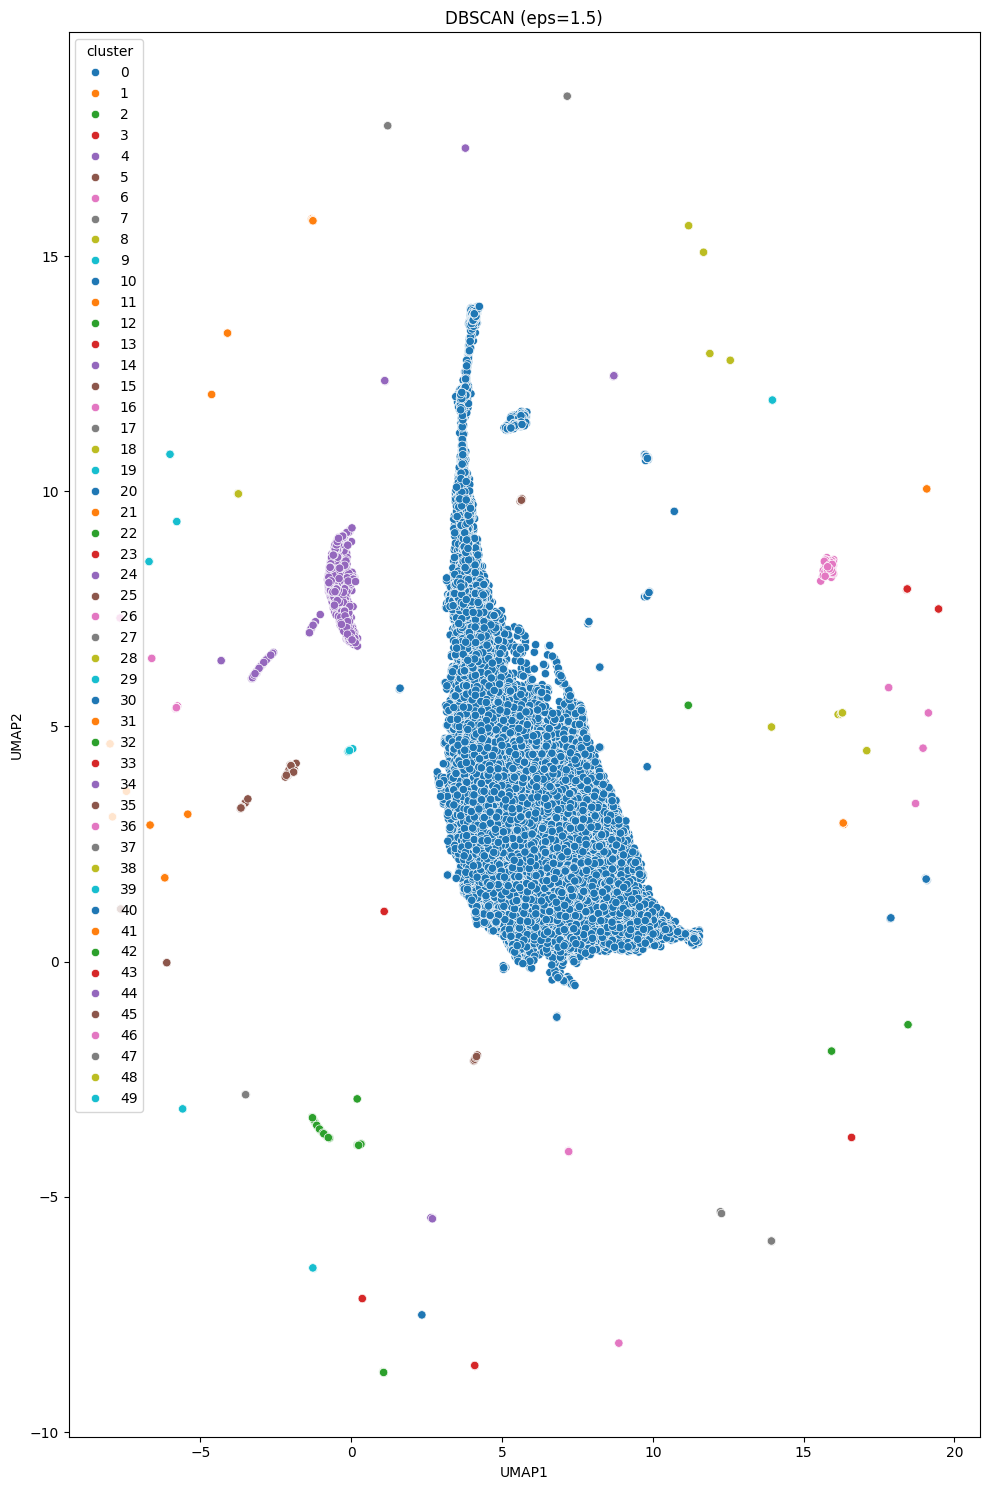


Cluster 0 summary:
Number of Movies: 58149
Top Genres: [('Drama', 32135), ('Comedy', 19179), ('Romance', 9040), ('Crime', 8230), ('Action', 8125)]
Top Languages: {'English': 26311, 'French': 2308, 'Japanese': 1975}
Top Countries: {'United States': 20815, 'United Kingdom': 2775, 'Japan': 2185}
Average Rating: 2.93, Total Ratings: 11063719.0

Cluster 1 summary:
Number of Movies: 51
Top Genres: [('Drama', 37), ('Romance', 18), ('Crime', 12), ('Comedy', 11), ('Adventure', 6)]
Top Languages: {'English': 33, 'English, French': 8, 'English, Italian': 2}
Top Countries: {'United States': 50, 'Hungary': 1}
Average Rating: 3.26, Total Ratings: 4629.0

Cluster 2 summary:
Number of Movies: 133
Top Genres: [('Drama', 62), ('Adventure', 55), ('Action', 45), ('Comedy', 35), ('Crime', 29)]
Top Languages: {'English': 57, 'English, Spanish': 9, 'English, French': 5}
Top Countries: {'United States': 80, 'United Kingdom, United States': 18, 'United States, United Kingdom': 10}
Average Rating: 3.81, Total 

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import matplotlib.font_manager as fm
from scipy.sparse import save_npz, load_npz
from collections import Counter
import warnings


warnings.filterwarnings("ignore", message=".*Trying to unpickle estimator.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden.*")




def load_data(filepath):
    return pd.read_csv(filepath)

def get_tfidf_embeddings(df, max_features=5000,
                         tfidf_embed_file="plot_tfidf_embeddings.npz",
                         tfidf_vectorizer_file="plot_tfidf_vectorizer.pkl"):
    if os.path.exists(tfidf_embed_file) and os.path.exists(tfidf_vectorizer_file):
        # X = csr_matrix(np.load(tfidf_embed_file)["data"])
        X = load_npz(tfidf_embed_file)
        vectorizer = joblib.load(tfidf_vectorizer_file)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        X = vectorizer.fit_transform(df['plot'].fillna(''))
        save_npz(tfidf_embed_file, X)
        joblib.dump(vectorizer, tfidf_vectorizer_file)
    return X, vectorizer

def multi_hot_encode_with_others(df, column, top_k=20):
    df[column + '_list'] = df[column].fillna('').apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
    all_items = df[column + '_list'].explode()
    top_items = all_items.value_counts().nlargest(top_k).index
    df[column + '_filtered'] = df[column + '_list'].apply(lambda items: [i if i in top_items else 'others' for i in items])
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column + '_filtered'])
    return encoded, mlb

def build_feature_matrix(df, plot_embeddings, actor_encoded, director_encoded):
    numerical_features = df[['avg_rating', 'num_rating']].fillna(0)
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(numerical_features)
    scaled_numerical_sparse = csr_matrix(scaled_numerical)
    return hstack([plot_embeddings, actor_encoded, director_encoded, scaled_numerical_sparse])

def reduce_dimensions(X, n_neighbors=15, min_dist=0.1, random_state=42, umap_file="X_umap_dbscan.npy"):
    if os.path.exists(umap_file):
        X_umap = np.load(umap_file)
    else:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
        X_umap = reducer.fit_transform(X)
        np.save(umap_file, X_umap)
    return X_umap

def find_best_dbscan(X, eps_values=[0.5, 1.0, 1.5], min_samples=5,
                     dbscan_cache_file="dbscan_labels.npy"):
    best_eps = None
    best_score = -1
    best_labels = None

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X)

        if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
            print(f"eps={eps}: Not enough clusters to calculate silhouette score.")
            continue

        try:
            score = silhouette_score(X, labels)
            print(f"eps={eps}: Silhouette Score = {score:.4f}")
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
        except Exception as e:
            print(f"eps={eps}: Failed to calculate silhouette score. Reason: {e}")

    if best_labels is not None:
        np.save(dbscan_cache_file, best_labels)

    return best_eps, best_labels

def visualize_clusters(X_umap, labels, title="DBSCAN Clustering"):
    df_vis = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
    df_vis["cluster"] = labels
    plt.figure(figsize=(10, 15))
    sns.scatterplot(data=df_vis, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10", legend='full')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def summarize_clusters(df):
    clusters = df['cluster'].unique()
    clusters = [c for c in clusters if c != -1]  

    for cluster in sorted(clusters):
        cluster_df = df[df['cluster'] == cluster]
        print(f"\nCluster {cluster} summary:")
        print(f"Number of Movies: {len(cluster_df)}")
        print(f"Top Genres: {Counter(','.join(cluster_df['genres'].dropna()).split(',')).most_common(5)}")
        print(f"Top Languages: {cluster_df['language'].value_counts().head(3).to_dict()}")
        print(f"Top Countries: {cluster_df['country'].value_counts().head(3).to_dict()}")
        print(f"Average Rating: {cluster_df['avg_rating'].mean():.2f}, Total Ratings: {cluster_df['num_rating'].sum()}")

def main():
    df = load_data("../1. Data_preparation/df_final_frozen_62188.csv")
    plot_embeddings, _ = get_tfidf_embeddings(df)
    actor_encoded, _ = multi_hot_encode_with_others(df, 'actors', top_k=20)
    director_encoded, _ = multi_hot_encode_with_others(df, 'director', top_k=20)
    
    X = build_feature_matrix(df, plot_embeddings, actor_encoded, director_encoded)
    X_umap = reduce_dimensions(X)

    best_eps, best_labels = find_best_dbscan(X_umap)
    if best_labels is None:
        print("DBSCAN failed to find meaningful clusters.")
        return

    df['cluster'] = best_labels
    visualize_clusters(X_umap, best_labels, f"DBSCAN (eps={best_eps})")
    summarize_clusters(df)

if __name__ == "__main__":
    main()
